## [Human Protein Atlas Competition](https://www.kaggle.com/c/human-protein-atlas-image-classification)
###### Introduction to the Human Protein Atlas

###### Our Goal
Classify the patterns of protein expression within images of human cells.
###### Challenges
Unlike most image labeling tasks, where binary or multiclass labeling is considered, in this competition each image have multiple labels. Multiclass multilabel task has its own specific affecting the design of the model and the loass function.


In [1]:
## Loading required libraries
import os
import sys
import time
import copy
import random
import logging
import numpy as np  # linear algebra
import pandas as pd  # for 
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict, defaultdict
from scipy.misc import imread
from sklearn.model_selection import RepeatedKFold
from skimage.transform import resize

import torch
from torvch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

path="/protein_atlas"
print(os.listdir(path))


ModuleNotFoundError: No module named 'torvch'

In [35]:
print ("1. Loading data & Converting data")
print ("----------------------------------------")
path="/media/haidro/harddisk1t/kaggle/protein_atlas"
print('Data files: ')
for file in os.listdir(path):
    print(file) 
print ("----------------------------------------")
train_label = pd.read_csv(path+"/train.csv")
print("There is %s samples in traininig set."%train_label.shape[0])
test_label = pd.read_csv(path+"/sample_submission.csv")
print("There is %s samples in testing set."%test_label.shape[0])
print ("----------------------------------------")
print ("There are in total 28 different labels present in the dataset, each image has various possible labels.")
# train_label
train_label.head()

1. Loading data & Converting data
----------------------------------------
Data files: 
test
.ipynb_checkpoints
sample_submission.csv
train
train.csv
----------------------------------------
There is 31072 samples in traininig set.
There is 11702 samples in testing set.
----------------------------------------
There are in total 28 different labels present in the dataset, each image has various possible labels.


,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


#### convert the Target into one-of_K scheme

In [37]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}
reverse_train_label = dict((v,k) for k,v in label_names.items())

def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row
for key in label_names.keys():
    train_label[label_names[key]] = 0
train_label = train_label.apply(fill_targets, axis=1)
train_label.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5],0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1],0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


###### Show the highest frequent labels in the dataset

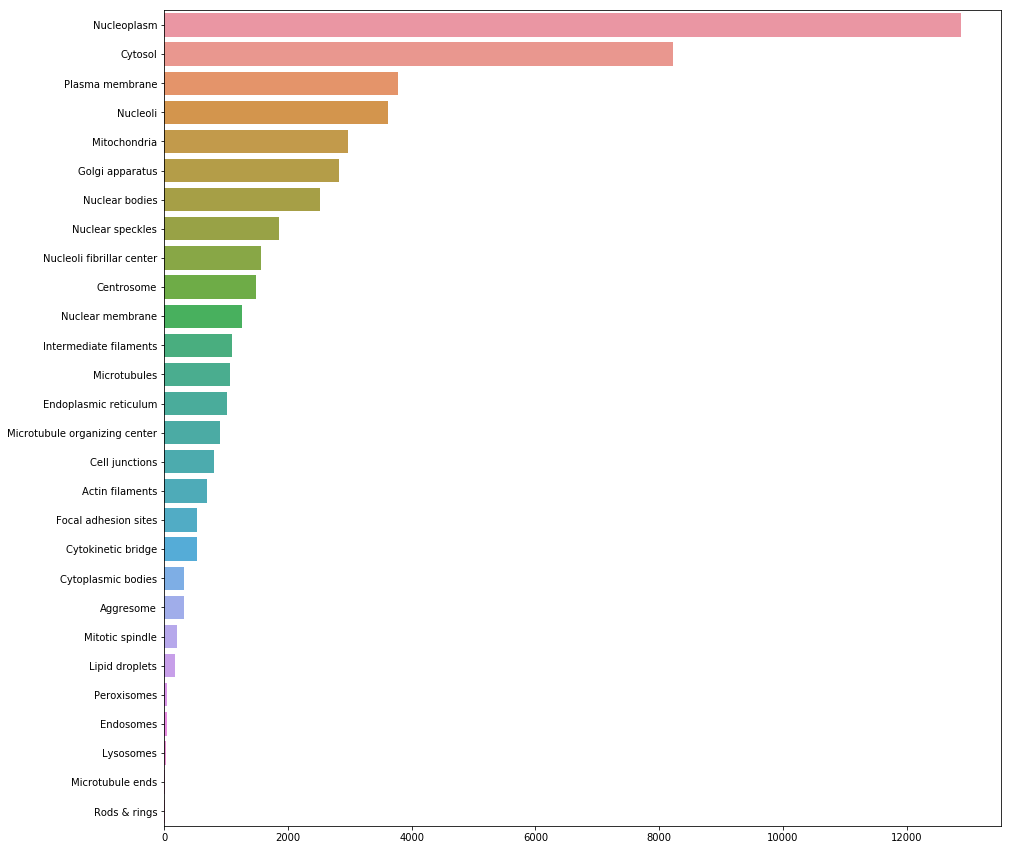

In [41]:
target_counts = train_label.drop(["Id", "Target"],axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index)

##### Build an batch loader

In [46]:
def load_image(basepath, image_id):
    images = np.zeros(shape=(4,512,512))
    images[0,:,:] = imread(basepath + image_id + "_green" + ".png")
    images[1,:,:] = imread(basepath + image_id + "_red" + ".png")
    images[2,:,:] = imread(basepath + image_id + "_blue" + ".png")
    images[3,:,:] = imread(basepath + image_id + "_yellow" + ".png")
    return images

def make_image_row(image, subax, title):
    subax[0].imshow(image[0], cmap="Greens")
    subax[1].imshow(image[1], cmap="Reds")
    subax[1].set_title("stained microtubules")
    subax[2].imshow(image[2], cmap="Blues")
    subax[2].set_title("stained nucleus")
    subax[3].imshow(image[3], cmap="Oranges")
    subax[3].set_title("stained endoplasmatic reticulum")
    subax[0].set_title(title)
    return subax

def make_title(file_id):
    file_targets = train_label.loc[train_label.Id==file_id, "Target"].values[0]
    title = " - "
    for n in file_targets:
        title += label_names[n] + " - "
    return title

class TargetGroupIterator:
    
    def __init__(self, target_names, batch_size, basepath):
        self.target_names = target_names
        self.target_list = [reverse_train_label[key] for key in target_names]
        self.batch_shape = (batch_size, 4, 512, 512)
        self.basepath = basepath
    
    def find_matching_data_entries(self):
        train_label["check_col"] = train_label.Target.apply(
            lambda l: self.check_subset(l)
        )
        self.images_identifier = train_label[train_label.check_col==1].Id.values
        train_label.drop("check_col", axis=1, inplace=True)
    
    def check_subset(self, targets):
        return np.where(set(self.target_list).issuperset(set(targets)), 1, 0)
    
    def get_loader(self):
        filenames = []
        idx = 0
        images = np.zeros(self.batch_shape)
        for image_id in self.images_identifier:
            images[idx,:,:,:] = load_image(self.basepath, image_id)
            filenames.append(image_id)
            idx += 1
            if idx == self.batch_shape[0]:
                yield filenames, images
                filenames = []
                images = np.zeros(self.batch_shape)
                idx = 0
        if idx > 0:
            yield filenames, images
            

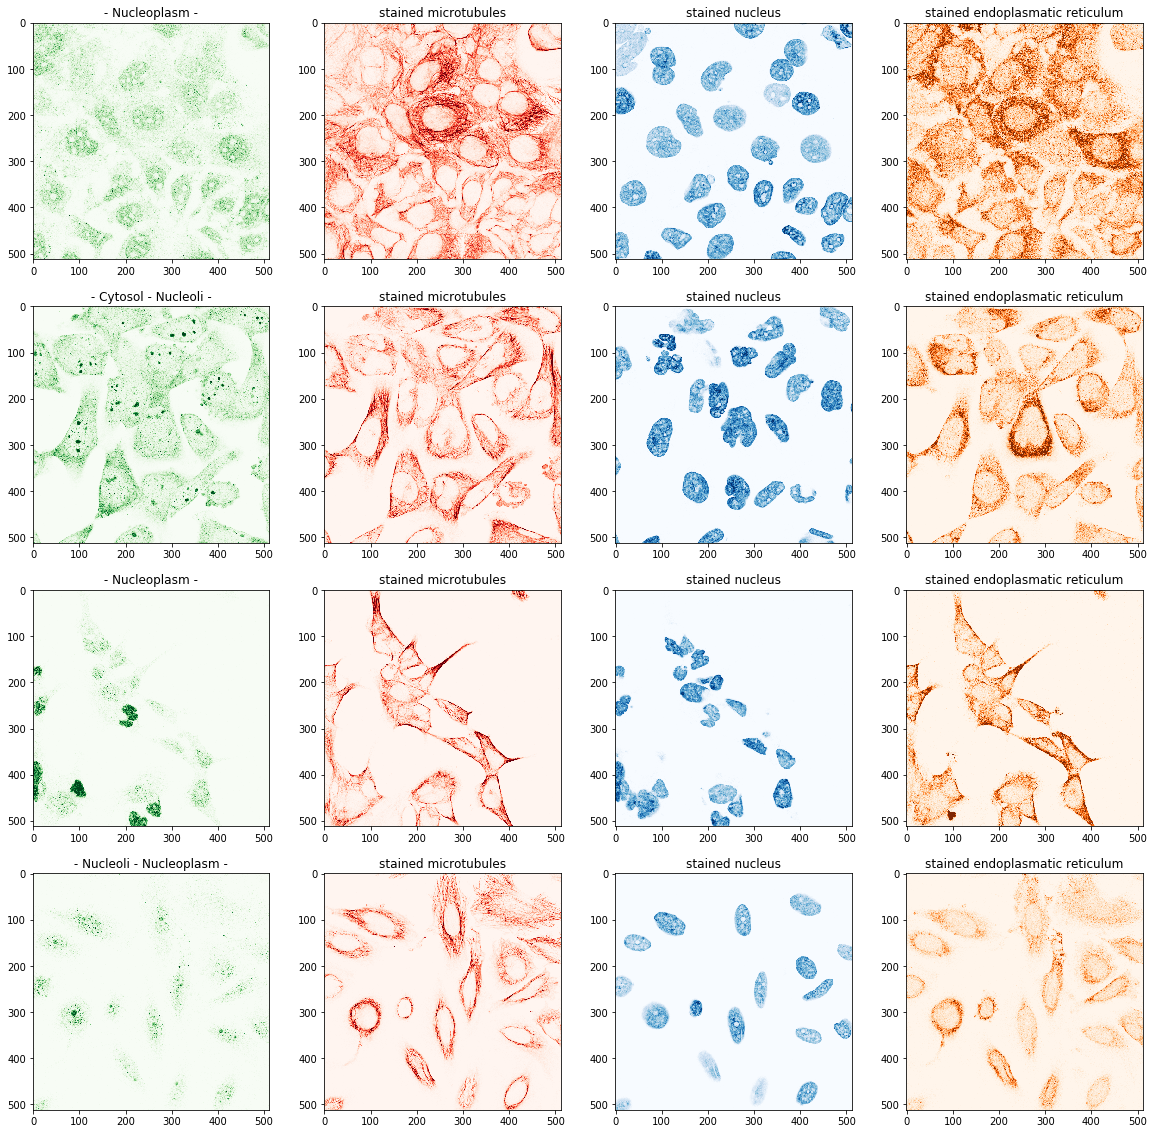

In [69]:
train_path=path+'/train/'
sub_labels = [ 'Nucleoplasm',"Plasma membrane",'Cytosol','Nucleoli','Mitochondria']
batch_size = 4
imageloader = TargetGroupIterator(sub_labels, batch_size, train_path)
imageloader.find_matching_data_entries()
iterator = imageloader.get_loader()
file_ids, images = next(iterator)

fig, ax = plt.subplots(len(file_ids),4,figsize=(20,5*len(file_ids)))
if ax.shape == (4,):
    ax = ax.reshape(1,-1)
for n in range(len(file_ids)):
    make_image_row(images[n], ax[n], make_title(file_ids[n]))

In [68]:
#### Split data sets
splitter = RepeatedKFold(n_splits=3, n_repeats=1, random_state=0)
partitions = []

for train_idx, test_idx in splitter.split(train_label.index.values):
    partition = {}
    partition["train"] = train_label.Id.values[train_idx]
    partition["validation"] = train_label.Id.values[test_idx]
    partitions.append(partition)
    print("TRAIN:", train_idx, "TEST:", test_idx)
    print("TRAIN:", len(train_idx), "TEST:", len(test_idx))
    

TRAIN: [    1     2     3 ... 31063 31064 31065] TEST: [    0     4     6 ... 31069 31070 31071]
TRAIN: 20714 TEST: 10358
TRAIN: [    0     4     6 ... 31069 31070 31071] TEST: [    1     2     3 ... 31060 31061 31065]
TRAIN: 20715 TEST: 10357
TRAIN: [    0     1     2 ... 31069 31070 31071] TEST: [   10    11    13 ... 31062 31063 31064]
TRAIN: 20715 TEST: 10357


In [104]:
class ModelParameter:
    
    def __init__(self, basepath,
                 num_classes=28,
                 image_rows=512,
                 image_cols=512,
                 batch_size=200,
                 n_channels=1,
                 row_scale_factor=4,
                 col_scale_factor=4,
                 shuffle=False,
                 n_epochs=1):
        self.basepath = basepath
        self.num_classes = num_classes
        self.image_rows = image_rows
        self.image_cols = image_cols
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.row_scale_factor = row_scale_factor
        self.col_scale_factor = col_scale_factor
        self.scaled_row_dim = np.int(self.image_rows / self.row_scale_factor)
        self.scaled_col_dim = np.int(self.image_cols / self.col_scale_factor)
        self.n_epochs = n_epochs
        
parameter = ModelParameter(train_path)
class ImagePreprocessor:
    
    def __init__(self, modelparameter):
        self.parameter = modelparameter
        self.basepath = self.parameter.basepath
        self.scaled_row_dim = self.parameter.scaled_row_dim
        self.scaled_col_dim = self.parameter.scaled_col_dim
        self.n_channels = self.parameter.n_channels
    
    def preprocess(self, image):
        image = self.resize(image)
        image = self.reshape(image)
        image = self.normalize(image)
        return image
    
    def resize(self, image):
        image = resize(image, (self.scaled_row_dim, self.scaled_col_dim))
        return image
    
    def reshape(self, image):
        image = np.reshape(image, (image.shape[0], image.shape[1], self.n_channels))
        return image
    
    def normalize(self, image):
        image /= 255 
        return image
    
    def load_image(self, image_id):
        image = np.zeros(shape=(512,512,4))
        image[:,:,0] = imread(self.basepath + image_id + "_green" + ".png")
        image[:,:,1] = imread(self.basepath + image_id + "_blue" + ".png")
        image[:,:,2] = imread(self.basepath + image_id + "_red" + ".png")
        image[:,:,3] = imread(self.basepath + image_id + "_yellow" + ".png")
        return image[:,:,0:self.parameter.n_channels]
preprocessor = ImagePreprocessor(parameter)
### example
example = images[0,0]
preprocessed = preprocessor.preprocess(example)
preprocessed.shape


(128, 128, 1)

In [ ]:
train = pd.read_csv(path+"/train.csv").values
test  = pd.read_csv(path+"/sample_submission.csv").values

print ("2. Converting data")
X_data  = train[:, 1:].reshape(train.shape[0], 1, 28, 28)
X_data  = X_data.astype(float)
X_data /= 255.0
X_data  = torch.from_numpy(X_data);
X_label = train[:,0];
X_label = X_label.astype(int);
X_label = torch.from_numpy(X_label);
X_label = X_label.view(train.shape[0],-1);
print (X_data.size(), X_label.size())


In [105]:
class MnistNet(nn.Module):
    def __init__(self):
        super(MnistNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(5,5))
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(5,5))
        self.bn2 = nn.BatchNorm2d(32)
        self.conv2_drop = nn.Dropout2d(p = 0.2)
        self.fc1 = nn.Linear(128, 100)
        self.fc2 = nn.Linear(100, 10)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3,3))
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3,3))
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=(3,3))
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=(1,1))
        self.bn6 = nn.BatchNorm2d(128)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.conv2_drop(F.max_pool2d(self.bn2(x),2))
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = F.max_pool2d(x,2)
        x = self.conv2_drop(x)
        x = F.relu(self.conv5(x))
        x = self.bn5(x)
        x = F.relu(self.conv6(x))
        x = self.bn6(x)
        size =  x.size()[1]*x.size()[2]*x.size()[3]
        #print(size)
        x = x.view(-1, size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

pass

net = MnistNet()

print(net)
use_gpu = torch.cuda.is_available()
net = net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.3, momentum = 0.1)


MnistNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_drop): Dropout2d(p=0.2)
  (fc1): Linear(in_features=128, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (bn6): BatchNorm2d

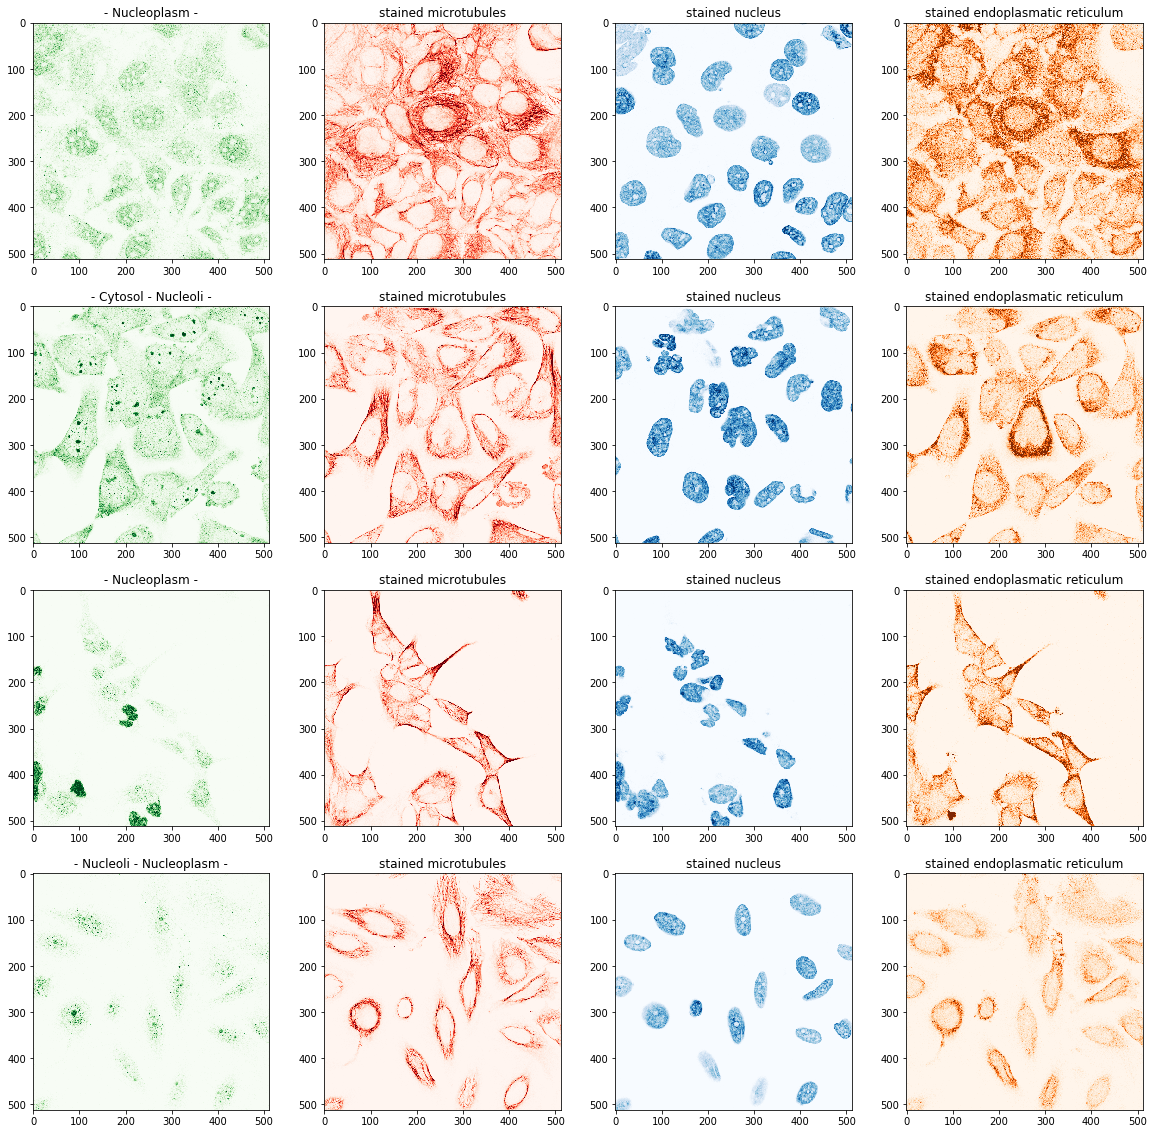

In [106]:
imageloader = TargetGroupIterator(sub_labels, batch_size, train_path)
imageloader.find_matching_data_entries()
iterator = imageloader.get_loader()
file_ids, images = next(iterator)

fig, ax = plt.subplots(len(file_ids),4,figsize=(20,5*len(file_ids)))
if ax.shape == (4,):
    ax = ax.reshape(1,-1)
for n in range(len(file_ids)):
    make_image_row(images[n], ax[n], make_title(file_ids[n]))